## Rosbank ML Competition

Задача состоит в том , чтобы спрогнозировать отток клиентов из банка.  
Импортируем необходимые библиотеки для дальнейшего анализа

In [1]:
# Для обработки данных и визуализации 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
%matplotlib inline

# Для подготовки данных к дальнейшему обучению 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve , roc_auc_score, auc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# Для обучения модели
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
import xgboost as xgb


Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [2]:
test_df = pd.read_csv(r'C:\Users\Кирик\Desktop\ds3-spring-2018\kaggle\rosssss\test_rosbank.csv')

In [3]:
raw_df = pd.read_csv(r'C:\Users\Кирик\Desktop\ds3-spring-2018\kaggle\rosssss\rossbank.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   PERIOD        490513 non-null  object 
 1   cl_id         490513 non-null  int64  
 2   MCC           490513 non-null  int64  
 3   channel_type  487603 non-null  object 
 4   currency      490513 non-null  int64  
 5   TRDATETIME    490513 non-null  object 
 6   amount        490513 non-null  float64
 7   trx_category  490513 non-null  object 
 8   target_flag   490513 non-null  int64  
 9   target_sum    490513 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


Видно , что только колонка channel_type содержит NaN значения

In [5]:
print("Всего уникальных клиентов: ",len(raw_df.cl_id.unique()))

Всего уникальных клиентов:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [6]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [7]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()   # то есть , то что не в списке cl_ids_test
print("Всего транзакций в тренировочном наборе данных: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()    # то что  в списке cl_ids_test
print("Всего транзакций в тестовом наборе данных: ", len(transactions_test))

Всего транзакций в тренировочном наборе данных:  391875
Всего транзакций в тестовом наборе данных:  98638


## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
3. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
4. **Обязательная часть**: на большом количестве фичей применить Lasso регрессию и посмотреть, какие переменные получают 0 в качестве коэффициентов
5. **Обязательная часть**: на фичах из MCC кодов применить PCA и посмотреть, какие фичи получаются и что они могут объяснять (для этого посмотреть на коэффициенты в *sklearn.decomposition.pca.components_* после построения главных компонент)
6. **Обязательная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. Сравнить качество модели до добавления компонент/после добавления/только на главных компонентах. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
8. **Дополнительная часть**: поучаствовать в соревновании - загрузить предсказания на https://boosters.pro/champ_15. Для этого необходимо использовать все данные из файла rosbank_train.csv, на них делать feature engineering и обучениеб затем делать предсказания для клиентов из файла rosbank_test.csv, предварительно создав фичи по аналогии с train.
9. Задания принимаются в виде ноутбука с кодом/картинками выполненной обязательной части + указанием места в leaderboard при решении дополнительной

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    

pip install nbformat в начале нужно для плотли

## Разберемся с MCC

#### Найдем уникальные значения MCC групп, и расписать какие из кодов в какую группу входят.

In [8]:
mcc_cod=pd.read_excel(r'C:\Users\Кирик\Desktop\ds3-spring-2018\kaggle\rosssss\Spravochnik_MCC_Cod.xlsx')
mcc_cod=mcc_cod.drop(labels=[0])
mcc_cod=mcc_cod.drop(columns=['Unnamed: 1','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 10'])
mcc_cod.rename(columns={'Unnamed: 2':'Count'},inplace=True)

#### Cделаю отступления по поводу воспроизведения графиков  
Так как Github не поддерживет интерактивный режим графиков plotly, то я просто в редакторе кода сохранил исходные данные в виде фото фотрмата (.png). Если всеже хочется подредактировать графики или изменить, это можно сделать скачав репрозиторий и запустив его в своем редакторе кода

In [9]:
fig = px.funnel_area( names=mcc_cod['Count'].unique(), values=mcc_cod['Count'].value_counts())
#  для динамичного редктирования графиков
fig.update_layout(
                  title={   'text' :'Распределение категорий MCC кодов на всех данных',
                            'x':0.5,
                            'xanchor': 'center'},
                  xaxis_title="x Axis Title",
                  yaxis_title="y Axis Title",
                  margin=dict(l=0.5, r=0.5, t=30, b=0))
fig.show(renderer='vscode')

!![title](graph\1.png)

посмотрим какими типами MCC пользовались клиенты которые продолжили пользоваться услугами банка после льготного периода

In [10]:
# выделим тот датафрейм в котором только оставшиеся клиенты
mcc_1=raw_df['MCC'].loc[raw_df['target_flag']==1]
mcc=mcc_1.copy(deep=True)
count_mcc=pd.DataFrame(mcc_1.value_counts())
count_mcc['code']=count_mcc.index
count_mcc.rename(columns={'MCC':'amount'},inplace=True)
count_mcc['code']=count_mcc.code.astype(str)

In [11]:
fig=px.bar(data_frame=count_mcc,x='code',y='count')
#  для динамичного редктирования графиков
fig.update_layout(
                  title={   'text' :'MCC коды в датасете',
                            'x':0.5,
                            'xanchor': 'center'},
                  xaxis_title="Номера MCC кодов",
                  yaxis_title="Колличество",
                  )
fig.show(renderer='vscode')

![title](graph\2.png)

видно,что основная часть сосредоточена на первых 10 значениях. Выведем их на новом графике

In [12]:
count_mcc=count_mcc.loc[count_mcc['count']>5000]
fig=px.bar(count_mcc,x='code',y='count')
fig.update_layout(
                  title={   'text' :'MCC коды в датасете',
                            'x':0.5,
                            'xanchor': 'center'},
                  xaxis_title="Номера MCC кодов",
                  yaxis_title="Колличество",
                  )
fig.show(renderer='vscode')

![title](graph\3.png)

## Посмотрим на распределения капитала по категориям транзакций

рассчиттаем на какие категории транзакций были больше всего простимулированны капиталом 

In [13]:
trx_cat=raw_df['trx_category'].value_counts() # выделяем категории

amount_trx=raw_df.groupby(['trx_category']).agg({'amount':'sum'}) # считаем общую сумму капиталовложений в каждой из категорий
amount_trx=amount_trx.reset_index()

fig=px.bar(amount_trx,x=amount_trx.trx_category,y=amount_trx.amount,width=1000, height=600)
fig.update_layout(
                  title={   'text' :'Категории транзакций',
                            'x':0.5,
                            'xanchor': 'center'},
                  xaxis_title="Тип транзакции",
                  yaxis_title="Вложенный капитал",
                  )
fig.show(renderer='vscode')

![title](graph\4.png)

POS - это, как правило, означает, что данная транзакция относится к покупке совершенной вами с помощью дебетовой карты  

DEPOSIT - это депозитный счет, средства с которого могут быть переведены другим лицам в виде платежей по сделкам, осуществляемым с помощью чеков или иных подобных платежных инструментов  

АТМ (Automatic Teller Machine) — автоматический банкомат. Электронная машина ATM позволяет снять деньги, внести наличные на счет. Поэтому , как я понимаю, это капитал который мы вкладывали или  снимали через банкоматы своего банка так и партнеров


Данные используем чтобы создадать сводную таблицу в которой представим кол-во потраченной суммы от кода валюты и типа транзакции и выведем графики.  


In [14]:
currency=raw_df['currency'].value_counts()

currency=currency.loc[currency>500].index.to_list() 
# создали список самых часто используемых валют и потом отсортировали в новый фрейм данные
# также учитывали и самые популярные категории транзакций (можно поменять в isin())
curr_df=raw_df.loc[raw_df['currency'].isin(currency) & raw_df['trx_category'].isin(['POS','DEPOSIT','WD_ATM_ROS','WD_ATM_PARTNER'])]


Всего использовалось 58 валют, но по капиталовожению они не были слишком объемны. Я взял 4 наиболее всетречающиеся валюты (более 500 раз)  
Расшифровка некоторых популярных валют  
- Российский рубль (810)  
- Доллар (840)  
- Евро (978)  
- Белорусский рубль (933)  

удивидельно , что сюда попал белорусский рубль
 


In [15]:
for i in currency:
    # сводная таблица агрегированная нами
    # пересоздавать h обязательно , а то она читает плохо после первого цикла
    h=curr_df.groupby(['currency','trx_category']).agg({'amount':'sum'})
    h=h.reset_index()
    h=h.loc[h.currency==i]
    fig=px.bar(h,x=h.trx_category,y=h.amount,title=f'{i}',width=800, height=400)
    fig.update_layout(
                  title={   'text' :f'Код валюты {i}',
                            'x':0.5,
                            'xanchor': 'center'},
                  xaxis_title="Тип транзакции",
                  yaxis_title="Вложенный капитал",
                  )
    fig.show(renderer='vscode')

![title](graph\5.png)
![title](graph\6.png)
![title](graph\7.png)
![title](graph\8.png)

## Теперь выделим дни и недели по которым совершались операции

In [16]:
# напишем функцию, преобразующую дату в нужный формат
from datetime import datetime
def change_date(date):
    curr_date=datetime.strptime(date, '%d/%m/%Y')
    return curr_date.strftime('%Y-%m-%d')

# создадим новую переменную , к которой применим функцию замены даты
period_new=curr_df[['PERIOD']].copy(deep=True)
period_new['PERIOD_NEW']=period_new.PERIOD.apply(change_date)
# в столбце PERIOD_NEW время записано как YYYY-MM-DD
# в столбце PERIOD время записано как DD/MM/YYYY

In [17]:
period_new['PERIOD_NEW'] = pd.to_datetime(period_new['PERIOD_NEW'], errors='coerce')

In [18]:
# создаем  новые столбцы, которые мы агрегируем из значений даты
period_new['Y']=period_new['PERIOD_NEW'].dt.year
period_new['M']=period_new['PERIOD_NEW'].dt.month
period_new['D']=period_new['PERIOD_NEW'].dt.day
period_new['target']=curr_df['target_flag']

In [19]:
date_frame=pd.DataFrame(period_new.copy(deep=True))

Выделим клиентов которые продолжили пользоваться банком. Посмотрим как дата влияет на целевой показатель

In [20]:
p_new=period_new.loc[period_new['target']==1]

In [21]:
def count_n(i):
    '''Функция считает кол-во категорий в Serias'''
    from collections import Counter
    current=Counter(i)
    return pd.DataFrame(current, index=['amount']).transpose()

In [22]:
count_year=count_n(p_new['Y'])
fig=px.bar( x=count_year.index, y=count_year['amount'])
fig.update_layout(
                  title={   'text' :'Клиенты продолживших пользоваться банком',
                            'x':0.5,
                            'xanchor': 'center'},
                  xaxis_title="Год ",
                  yaxis_title="Колличество человек",
                  )
fig.show(renderer='vscode')

![title](graph\9.png)

Видно из графика, что больше всего клиентов продолжило пользоваться , которые в 2017 году совершали опепрации.  
Тогда можно рассмотреть, в каком месяце тогда сосредоточены люди продолжающие пользоваться услугами банка

In [23]:
month=['январь', 'февраль','март','апрель','май','июнь','июль','август','сентябрь','октябрь','ноябрь','декабрь']

In [24]:
# Выделим 2017 год и разобьем по месяцам
count_month=count_n(p_new['M'].loc[p_new['Y']==2017])
fig=px.bar( x=month, y=count_month['amount'].sort_index())
fig.update_layout(
                  title={   'text' :'Клиенты продолживших пользоваться банком в 2017 году',
                            'x':0.5,
                            'xanchor': 'center'},
                  xaxis_title="Месяца",
                  yaxis_title="Колличество человек",
                  )
fig.show(renderer='vscode')

![title](graph\10.png)

В основном операции приходятся на лето и конец весны. используем эти данные для дальнейшего создания фич

In [25]:
new_date=period_new['PERIOD_NEW']
new_date = pd.to_datetime(new_date).dt.dayofweek
# добавим необходимую форматированную дату к нашему фрейму
curr_df=curr_df.join(new_date)

# избавимся от старого
curr_df.drop(['PERIOD'],axis=1,inplace=True)

In [26]:
m=period_new['M'].to_numpy() 
for i in range(0,len(m)):
    if m[i] in [6,7,8,]:
        # 1 значит , что операция совершена ночью
        m[i]=1
    else:
        # 0 значит опреация совершена днем
        m[i]=0
m=pd.DataFrame(m,columns=['summer'])
curr_df=curr_df.join(m['summer'])


## Теперь выделим время сутое и постараемся провести аналитику , зависит ли ночью или днем совершались покупки

In [27]:
import re
# С помощью регулярных выражений вытягиваем из столбца TRDATETIME информаци. о времени
time=[]
list_time=curr_df.TRDATETIME.to_list()
for i in list_time:
    patern=re.findall('(00|[0-9]|1[0-9]|2[0-3]):([0-9]|[0-5][0-9]):([0-9]|[0-5][0-9])$',i)
    time.extend(patern)
# преобразуем данные во фрейм
time=pd.DataFrame(time,columns=['hour','minute','second'])
#curr_df=curr_df.join(time['hour'])
t=time['hour'].to_numpy() 
# я специально пребразовал в ndarray тк он дает огромный выйгрыш по времени
# ссылка на статью 
# https://medium.com/nuances-of-programming/эффективное-итерирование-по-строкам-в-pandas-dataframe-43aa7d2588cb


In [28]:
# преобразуем значения в удобный формат
for i in range(0,len(t)):
    if t[i]=='00':
        # 1 значит , что операция совершена ночью
        t[i]=1
    else:
        # 0 значит опреация совершена днем
        t[i]=0
t=pd.DataFrame(t,columns=['night'])

In [29]:
from collections import Counter
cnt=Counter(time['hour'])
cnt_hour= pd.DataFrame(cnt, index=[0]).transpose()
fig=px.bar(cnt_hour, labels=dict(index="hour",))
fig.show(renderer='vscode')

Видно , что большинство операций совершалось в 12 часов ночи. Причем на несколько порядков больше чем других значений. поэтому выделим как отдельную фичу кол-во совершенных операций в 00 часов

In [30]:
curr_df=curr_df.join(t['night'])


## Создадим сводную таблицу по нашим данным

In [31]:
curr_df.drop('TRDATETIME',axis=1,inplace=True)

на основе наших предположений агрегируем таблицу

Самые часто встречающиеся MCC среди оставшихсф клиентов имеют код  
5411, 6011, 5814, 5812, 5499, 5541, 5912   
почти все относятся к категории Retail Purchase  
выберем только эти значения для агрегации

In [32]:
mcc_list=[5411, 6011, 5814, 5812, 5499, 5541, 5912]

В основном пользовались только рублем и самые объемные по колличеству оборота денег категории транзакций  
'POS' , 'WD_ATM_ROS' 

In [33]:
currency_list=[810,]
trx_category_list=['POS','WD_ATM_ROS','DEPOSIT']
night_list=[1]
# Тк 1 и 2 канал привлечения самые популярые и информативные, то используем только их
channel_list=['type1','type2']

In [34]:
df_table=curr_df.loc[(curr_df.MCC.isin(mcc_list))
                  &(curr_df.channel_type.isin(channel_list))
                  &(curr_df.trx_category.isin(trx_category_list))
                  &(curr_df.currency.isin(currency_list)),
                  ]
df_cp=df_table.copy(deep=True)
df_table.drop(columns=['amount','target_flag','target_sum','PERIOD_NEW','summer','night'],axis=1,inplace=True)

C:\Users\Кирик\AppData\Local\Temp\ipykernel_13596\3734523923.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
df_model_agg=df_table.groupby(['cl_id','channel_type', 'MCC', 'trx_category',]).agg({'cl_id':'count'})
df_model_agg=df_model_agg.rename(columns={'cl_id':'trx_count'})
#df_model_agg
df_model_agg.unstack(level=[1,2,3]).reset_index()


cl_id trx_count                                                 \
channel_type            type2                                                  
MCC                      5411  5541 5812  5814 5912  5499       6011           
trx_category              POS   POS  POS   POS  POS   POS WD_ATM_ROS DEPOSIT   
0               269      48.0   3.0  9.0  54.0  7.0   NaN        NaN     NaN   
1               272      15.0   6.0  NaN   1.0  NaN  44.0       17.0     NaN   
2               273      64.0   NaN  4.0  58.0  4.0   NaN        NaN     NaN   
3               274      25.0  13.0  6.0   3.0  7.0  63.0        NaN     NaN   
4               277      11.0   NaN  7.0   NaN  1.0   NaN        NaN     NaN   
...             ...       ...   ...  ...   ...  ...   ...        ...     ...   
4641          10210       NaN   NaN  NaN   NaN  NaN   NaN        NaN     NaN   
4642          10212       NaN   NaN  NaN   NaN  NaN   NaN        NaN     NaN   
4643          10213       NaN   NaN  NaN   NaN  NaN   NaN        NaN     NaN   
4644          10214       NaN   NaN  NaN   NaN  NaN   NaN        NaN     NaN   
4645          10215       NaN   NaN  NaN   NaN  NaN   NaN        NaN     NaN   

                                                                   
channel_type type1                                                 
MCC           5411  5499 5541  5814  5912 5812    6011             
trx_category   POS   POS  POS   POS   POS  POS DEPOSIT WD_ATM_ROS  
0              NaN   NaN  NaN   NaN   NaN  NaN     NaN        NaN  
1              NaN   NaN  NaN   NaN   NaN  NaN     NaN        NaN  
2              NaN   NaN  NaN   NaN   NaN  NaN     NaN        NaN  
3              NaN   NaN  NaN   NaN   NaN  NaN     NaN        NaN  
4              NaN   NaN  NaN   NaN   NaN  NaN     NaN        NaN  
...            ...   ...  ...   ...   ...  ...     ...        ...  
4641          31.0  22.0  6.0  15.0   1.0  4.0     2.0        3.0  
4642           NaN   NaN  NaN   NaN   NaN  NaN     7.0        NaN  
4643          29.0   1.0  3.0   7.0   1.0  8.0     8.0        NaN  
4644          24.0   6.0  2.0   2.0  15.0  2.0     NaN        NaN  
4645           9.0   NaN  NaN   1.0   NaN  2.0     4.0        NaN  

[4646 rows x 17 columns]

In [36]:
df_model_agg.head(20)

trx_count
cl_id channel_type MCC  trx_category           
269   type2        5411 POS                  48
                   5541 POS                   3
                   5812 POS                   9
                   5814 POS                  54
                   5912 POS                   7
272   type2        5411 POS                  15
                   5499 POS                  44
                   5541 POS                   6
                   5814 POS                   1
                   6011 WD_ATM_ROS           17
273   type2        5411 POS                  64
                   5812 POS                   4
                   5814 POS                  58
                   5912 POS                   4
274   type2        5411 POS                  25
                   5499 POS                  63
                   5541 POS                  13
                   5812 POS                   6
                   5814 POS                   3
                   5912 POS                   7

In [37]:
def pvt_table(two_cols_df):
    agg_vals=two_cols_df.groupby(['cl_id',two_cols_df.columns[1]]).agg({'cl_id':'count'}).rename(columns={'cl_id':'cnt_trx'}).reset_index()
    pvt_new=agg_vals.pivot_table(
                        index='cl_id',
                        columns=two_cols_df.columns[1],
                        values='cnt_trx',
                        aggfunc='sum')
    return pvt_new


In [38]:

for i in range(0,len(df_table.columns)-1):
    if i==0:
        vt_final=pvt_table(df_table[['cl_id',df_table.columns[i+1]]])
    else:
        vt_final=vt_final.merge(pvt_table(df_table[['cl_id',df_table.columns[i+1]]]),on='cl_id', )
       

In [39]:
agg_target=df_cp.groupby(['cl_id','target_flag']).agg({'target_flag':'count'})

In [40]:
trg=[]
for i in range(0,len(vt_final)):
    t=agg_target.index[i][1]
    trg.append(t)
trg=pd.DataFrame(trg,columns=['target'])
pvt_final=vt_final.join(trg,)
pvt_final.reset_index(inplace=True)
pvt_final

,cl_id,5411,5499,5541,5812,5814,5912,6011,type1,type2,810,DEPOSIT,POS,WD_ATM_ROS,target
0,269,48.0,NaN,3.0,9.0,54.0,7.0,NaN,NaN,121.0,121,NaN,121.0,NaN,1.0
1,272,15.0,44.0,6.0,NaN,1.0,NaN,17.0,NaN,83.0,83,NaN,66.0,17.0,0.0
2,273,64.0,NaN,NaN,4.0,58.0,4.0,NaN,NaN,130.0,130,NaN,130.0,NaN,1.0
3,274,25.0,63.0,13.0,6.0,3.0,7.0,NaN,NaN,117.0,117,NaN,117.0,NaN,1.0
4,277,11.0,NaN,NaN,7.0,NaN,1.0,NaN,NaN,19.0,19,NaN,19.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4641,10210,31.0,22.0,6.0,4.0,15.0,1.0,5.0,84.0,NaN,84,2.0,79.0,3.0,NaN
4642,10212,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7.0,NaN,7,7.0,NaN,NaN,NaN
4643,10213,29.0,1.0,3.0,8.0,7.0,1.0,8.0,57.0,NaN,57,8.0,49.0,NaN,NaN
4644,10214,24.0,6.0,2.0,2.0,2.0,15.0,NaN,51.0,NaN,51,NaN,51.0,NaN,NaN


## Сразу разделим на обучающиеся и тестовые данные

In [41]:
col=list(pvt_final.columns[:-1]) #длина списка колонок датафреймов всех кроме последнего
# Для того чтобы все работало без нареканий нужно названия столбцов
#  датарейма перевести в строчный тип (чтоб не ругалось лишний раз)
col_num=[i for i in col if type(i)==int]
for i in col_num:
    pvt_final.rename(columns={i:str(i)},inplace=True)

pvt_final.fillna(0,inplace=True) # заполним нулями занчения NaN
y = pvt_final['target'].copy(deep=True)
pvt_final.drop(['target','cl_id'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(pvt_final, y, test_size=0.3, random_state=50)

## Применим метод главных компонент к столбцу MCC

Сначала преобразуем данные для обработки и проведем стандартизацию значений

In [42]:

# перед тем как начинать обучать необходимо стандартизировать данные, чтобы устранить разбросс 
# значений тем самым оптимизтровать учителя
st_scale=StandardScaler()
# fit_transfoorm только на обучаемых данных
df_PCA_scaled=st_scale.fit_transform(X_train,y_train)
st_PCA_test=st_scale.transform(X_test)

df_PCA_scaled=pd.DataFrame(df_PCA_scaled).dropna()
st_PCA_test=pd.DataFrame(st_PCA_test).dropna()

In [43]:
st_PCA_test.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000
mean,-0.040382,-0.035444,-0.049892,-0.069559,-0.018035,-0.023573,-0.014486,-0.012207,-0.056623,-0.060295,0.022159,-0.060308,-0.036426
std,0.992880,0.878717,0.942015,0.876735,0.950028,0.914644,1.042186,0.962917,0.915097,0.945564,1.012922,0.946260,1.092073
min,-0.944086,-0.494227,-0.628650,-0.534194,-0.536880,-0.680951,-0.793831,-0.772098,-0.505460,-1.146356,-0.577794,-1.066276,-0.528440
25%,-0.795384,-0.494227,-0.628650,-0.534194,-0.536880,-0.680951,-0.691214,-0.772098,-0.505460,-0.843305,-0.577794,-0.848213,-0.528440
50%,-0.349280,-0.407966,-0.473856,-0.360361,-0.411269,-0.332383,-0.280745,-0.441603,-0.505460,-0.256142,-0.419697,-0.293145,-0.398958
75%,0.431404,0.023343,0.145322,-0.012695,0.028371,0.190469,0.334957,0.484785,-0.136974,0.501486,0.212692,0.519632,-0.010511
max,8.238238,8.476984,9.123397,9.200449,8.632741,7.336116,19.113884,5.076665,5.588308,4.365394,11.279507,4.682640,24.591079


In [44]:
pca=PCA(n_components=7,
        iterated_power=500
) 
train_PCA=pca.fit_transform(df_PCA_scaled) 
test_PCA=pca.transform(st_PCA_test) 

In [45]:
print(sum(pca.explained_variance_ratio_) )
print(pca.explained_variance_ratio_)

0.9135365099815278
[0.38074469 0.14615464 0.13788009 0.07557511 0.06125394 0.05644053
 0.05548751]


видно что MCC объясняет 91% данных

## Регуляризация

Для начала избавимся от ненужных столбцов и закодируем данные  
МОЖНО доавить больше признаков и протестить какие из гих вообще нужны

In [46]:
mod_df=st_scale.fit_transform(X_train,y_train)
mod_df=pd.DataFrame(mod_df)
mod_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,3.252000e+03,3.252000e+03,3.252000e+03,3.252000e+03,3.252000e+03,3.252000e+03,3.252000e+03,3.252000e+03,3.252000e+03,3.252000e+03,3.252000e+03,3.252000e+03,3.252000e+03
mean,-2.621929e-17,2.184941e-18,8.412022e-17,-5.680846e-17,2.184941e-18,1.092470e-18,-2.512682e-17,6.117834e-17,4.042140e-17,-4.369882e-18,1.392900e-17,-3.495905e-17,-2.840423e-17
std,1.000154e+00,1.000154e+00,1.000154e+00,1.000154e+00,1.000154e+00,1.000154e+00,1.000154e+00,1.000154e+00,1.000154e+00,1.000154e+00,1.000154e+00,1.000154e+00,1.000154e+00
min,-9.440860e-01,-4.942272e-01,-6.286499e-01,-5.341941e-01,-5.368799e-01,-6.809512e-01,-7.938309e-01,-7.720977e-01,-5.054598e-01,-1.146356e+00,-5.777943e-01,-1.066276e+00,-5.284397e-01
25%,-7.953844e-01,-4.942272e-01,-6.286499e-01,-5.341941e-01,-5.368799e-01,-6.809512e-01,-6.912138e-01,-7.720977e-01,-5.054598e-01,-8.054233e-01,-5.777943e-01,-8.283893e-01,-5.284397e-01
50%,-2.749288e-01,-4.079656e-01,-4.738555e-01,-3.603612e-01,-4.112687e-01,-3.323831e-01,-2.807455e-01,-4.315876e-01,-5.054598e-01,-2.372017e-01,-4.196969e-01,-2.534978e-01,-3.989576e-01
75%,4.685793e-01,2.334263e-02,3.001164e-01,7.422109e-02,2.837068e-02,3.647532e-01,3.349571e-01,4.897928e-01,2.252005e-02,5.772493e-01,2.126925e-01,5.592800e-01,1.189706e-01
max,8.870220e+00,1.451530e+01,1.190970e+01,1.406777e+01,9.386409e+00,2.389310e+01,1.193069e+01,5.857835e+00,9.570156e+00,7.509553e+00,1.096331e+01,7.933751e+00,1.539785e+01


In [47]:
from sklearn import linear_model

l1 = linear_model.Lasso(alpha=0.05,max_iter=15)
train_reg=l1.fit(mod_df.values,y_train.values )

print(l1.coef_)
print(l1.intercept_)


[-0.         -0.         -0.          0.          0.         -0.
 -0.         -0.03503334  0.13987418 -0.         -0.         -0.
  0.        ]
0.24692496924969248


L1 регуляризация может полностью обнулить часть коэффициентов и, таким образом, исключить соответствующие признаки из модели. Эта особенность Lasso регрессии называется parameter sparcity.

зануленные коэфиценты отбрасываются. Как видно имеет больше 0,1 только параметр 'channel_type'

## Обучение модели

воспользуемся методом XGBoost

In [48]:
clf_xgb=xgb.XGBClassifier(max_depth=5)
clf_xgb.fit(X_train,y_train)
y_pred_xgb_test=clf_xgb.predict_proba(X_test)[:,1]
y_pred_xgb_train=clf_xgb.predict_proba(X_train)[:,1]

Train:
ROC AUC: 0.9927


Test:
ROC AUC: 0.8371


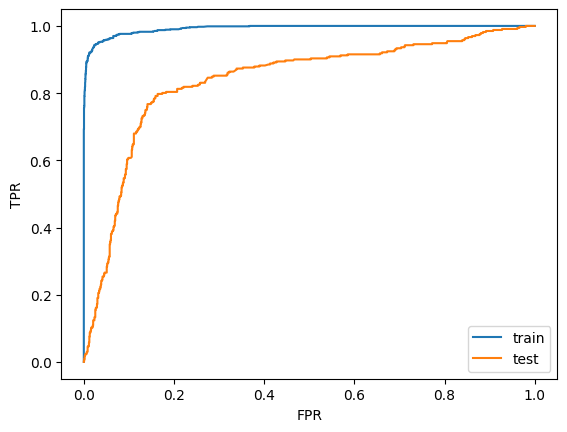

In [49]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.legend();

это разобрать надо  
https://translated.turbopages.org/proxy_u/en-ru.ru.fac085b4-64a895ba-16ef5c60-74722d776562/https/github.com/hyperopt/hyperopt/wiki/FMin

In [50]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


params = {'n_estimators': 50,
          'learning_rate': 0.03,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': 4}

#функция, которую будем МИНИМИЗИРОВАТЬ
def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_jobs'] = -1
    print("Training with params : ", params)
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred_xgb_test = clf.predict_proba(X_test)[:, 1]
    auc = calc_auc(y_test, y_pred_xgb_test, prin=False)
    result = {'loss': 1-auc, 'status': STATUS_OK}
    print('TEST ROC AUC: {0:.4f}'.format(auc))
    return result



space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
         'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         'silent' : 1,
         'n_estimators': 50,
         'learning_rate': 0.03
         }
trials = Trials()

best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20)

params = {'n_estimators': 50,
          'learning_rate': 0.03,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': 4}

Training with params :                                
{'colsample_bytree': 0.8, 'gamma': 0.9500000000000001, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4.0, 'n_estimators': 50, 'silent': 1, 'subsample': 1.0, 'n_jobs': -1}
[10:08:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

TEST ROC AUC: 0.8409                                  
Training with params :                                                           
{'colsample_bytree': 0.8500000000000001, 'gamma': 0.65, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 5.0, 'n_estimators': 50, 'silent': 1, 'subsample': 0.55, 'n_jobs': -1}
[10:08:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

TEST ROC AUC: 0.8416                          

In [74]:
from sklearn.linear_model import LogisticRegression as log_reg
from sklearn.tree import ExtraTreeClassifier as tree_class
from sklearn.model_selection import cross_val_score as cv

In [52]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

В данном случаем мы разоберем как оптимизировать классификатор логистической регрессии. Старались получить максимальный покзатель метрики в зависимости от настраиваемых параметров

In [76]:
# space - определяет пространство переменных значений классификатора 
#  грубо говоря по нему проходит выборка значений гиперпараметров

# LogisticRegression
space_log_reg= {'penalty': hp.choice('penalty',['l2']),
        'C': hp.quniform('C',0.01,0.2,0.01),
        'random_state': hp.quniform('random_state',0,100,10),
        'solver': hp.choice('solver',['lbfgs', 'newton-cg', 'newton-cholesky',]),
        'max_iter': hp.quniform('max_iter',0,100,10),
}

# objective- модель на которой мы тестируем все гиперпараметры
# закладываем туда саму модель и обучаем,прогназируем
def objective (space):
    model=log_reg(
        penalty=space['penalty'],
        C=space['C'],
        #random_state=space['random_state'],
        solver=space['solver'],
    )
    roc_auc=cv(model,X_train,y_train,cv=4,scoring='roc_auc').mean()
    return {'loss': roc_auc,  'status': STATUS_OK}

# передавая объект trials напрямую, мы можем проверить все возвращаемые значения, которые были вычислены во время эксперимента. 
# но здесь этого не надо, поэтому дефолтное значение никуда его не надо включать
trials=Trials()

# считаем какая варифция гиперпараметров дает наибольшее начение метрики
best =fmin(fn=objective,
            space=space_log_reg,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
)

print (best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [00:27<00:00,  1.80trial/s, best loss: 0.836653009164108]
{'C': 0.15, 'max_iter': 0.0, 'penalty': 0, 'random_state': 20.0, 'solver': 0}


надо обучить и сравнить на тестовой выборке, а то толку от этого

Теперь рассмотрим древо решений

In [79]:
# DecisionTreeClassifier
space_DTC= {'criterion': hp.choice('criterion',['gini', 'entropy', 'log_loss']),
                'splitter': hp.choice('splitter', ['best','random']),
                'max_depth': hp.choice('max_depth',[2, 3, 4, 5, 6, 7]),
                'min_samples_leaf':hp.choice('min_samples_leaf',[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
                'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.1,0.5,0.02),
                'max_features': hp.choice('max_features',['sqrt','log2']),
                'random_state':hp.quniform('random_state',0,100,10),
                'max_leaf_nodes':hp.choice('max_leaf_nodes',[2, 3, 4, 5, 6, 7, 8, 9, 10]),
                'min_impurity_decrease': hp.quniform('min_impurity_decrease',0,50,10)
}

def objective_DTC (space):
    model=tree_class(
        criterion=space['criterion'],
        splitter=space['splitter'],
        max_depth=space['max_depth'],
        min_samples_leaf=space['min_samples_leaf'],
        #min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
        max_features=space['max_features'],
        #max_leaf_nodes=space['max_leaf_nodes'],
        #in_impurity_decrease=space['min_impurity_decrease']    
    )
    
    roc_auc=cv(model,X_train,y_train,cv=4,scoring='roc_auc').mean()
    return {'loss': roc_auc,  'status': STATUS_OK}

trials=Trials()

best = fmin(fn=objective_DTC,
            space=space_DTC,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
)
best

  4%|▍         | 2/50 [00:00<00:06,  7.15trial/s, best loss: 0.7287985716681495]

100%|██████████| 50/50 [00:10<00:00,  4.64trial/s, best loss: 0.510668674600852]


{'criterion': 2,
 'max_depth': 0,
 'max_features': 1,
 'max_leaf_nodes': 6,
 'min_impurity_decrease': 40.0,
 'min_samples_leaf': 2,
 'min_weight_fraction_leaf': 0.26,
 'random_state': 50.0,
 'splitter': 1}

## Домашняя работа 2

1. **Обязательная часть**: на том же наборе данных провести feature engineering:
    - создать Weights of Evidence (WOE) фичи на тех переменных, где категорий большое количество
    - cделать one hot encoding там, где необходимо
    - по желанию посчитать каунты (counts)
    
2. **Обязательная часть**: обучить linear SVM и SVM с нелинейным ядром - сравнить время обучения и результат метрики оценки качества (ROC AUC) двух алгоритмов между собой и сравнить с линейной моделью (лог.рег)

Weight of Evidence (WoE) показывает предсказательную силу независимой переменной по отношению к зависимой переменной. Поскольку WoE возник из мира кредитного скоринга, его обычно описывают как меру разделения на «хороших» и «плохих» клиентов. «Плохие клиенты» — это те, которые не выполнили свои обязательства по кредиту. «Хорошие клиенты» — те, которые выплатили кредит.

In [81]:
pvt=pvt_final.join(trg,)
pvt.fillna(0,inplace=True)
pvt

In [83]:
def woe_iv(df_train, col , target_col):
    '''На основе коэффициентов WoE вычисляется величина, определяющая значимость признака в модели бинарной классификации, называемая информационным индексом (IV).'''
    good=df_train[df_train[target_col]==1][col] # все положительные результаты dataframe
    bad=df_train[df_train[target_col]==0][col] # все отрицательные результаты dateframe

    good_count=len(good) # кол-во всех положительных
    bad_count=len(bad) # кол-во всех отрицательных

    all=good_count+bad_count # кол-во свех рез
    
    pos_X=good[col].sum() # кол-во положительных рез в одном из признаков
    neg_X=bad[col].sum() # кол-во отрицательных рез в одном из признаков
    all_X=pvt[col].sum()# кол-во всех признаков в одном из признаков
    
    dist_good=good_count/pos_X
    dist_bad=bad_count/neg_X

    import numpy as np

    woe=np.log(dist_good / dist_bad)
    information_value=(dist_good-dist_bad)*woe
    iv=information_value.sum()

    return  'расчитаное IV',iv, information_value

        

In [85]:
col_w=list(pvt.columns[:-1]) #длина списка колонок датафреймов всех кроме последнего
# Для того чтобы все работало без нареканий нужно названия столбцов
#  датарейма перевести в строчный тип (чтоб не ругалось лишний раз)
#col_num_w=[i for i in col_w if type(i)==int]

In [86]:
woe_iv( pvt, col_w, 'target')

('расчитаное IV',
 0.7146429140265087,
 5411          0.002157
 5499          0.029577
 5541          0.022782
 5812          0.093697
 5814          0.078300
 5912          0.026692
 6011          0.001734
 type1         0.001354
 type2         0.275247
 810           0.002143
 DEPOSIT       0.050845
 POS           0.002998
 WD_ATM_ROS    0.127116
 dtype: float64)

likelihood encoding  
https://www.kaggle.com/code/vprokopev/mean-likelihood-encodings-a-comprehensive-study
считаем долю таргета в категории, т.е. берем какой-то признак считаем сколько с положительным таргетом и сколько всего. Ищем отношение. 

In [87]:
def get_counts(df_train, df_test, col, target_col):
    category_val_dict = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[col].value_counts()
    ).to_dict()
    df_train[col + '_counts'] = df_train[col].apply(category_val_dict.get)
    df_test[col + '_counts'] = df_test[col].apply(category_val_dict.get)
    return df_train, df_test

Линейный SVM

по ссылочкам почитать полезную информацию

https://manufacturingnet.readthedocs.io/en/latest/shallow_learning_methods/svm.html

https://habr.com/ru/companies/ods/articles/484148/

In [90]:

pvt.drop(columns=['target'], inplace=True)

col_num=[i for i in col if type(i)==int]
for i in col_num:
    pvt.rename(columns={i:str(i)},inplace=True)

In [91]:
scaler=StandardScaler()
SVC_df=scaler.fit_transform(X_train,y_train,)

test_svc=scaler.transform(X_test)

In [92]:
cr_val=cross_val_score(

    LinearSVC(C=0.05, loss="hinge", random_state=50, max_iter=100000),
    test_svc, 
    y_test, 
    scoring='roc_auc', 
    
    )
cr_val.mean()

C:\Users\Кирик\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



C:\Users\Кирик\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

C:\Users\Кирик\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

C:\Users\Кирик\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

C:\Users\Кирик\AppData\Local\Packages\PythonSoftware

0.8211010253654459